In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import numpy as np
from datetime import datetime
from datetime import date
import statsmodels.api as sm
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt 
fig = plt.gcf() 
fig.set_size_inches(12, 8)
import seaborn as sns
%matplotlib inline
from pathlib import Path, PureWindowsPath

# AirBnB and Gentrification 

This analysis is not used to prove a causal link to gentrification in Sydney, Australia and AirBnB. Rather, it uses scraped data to analyze the significance of housing commodification, or the classification of housing as an asset and not as shelter. 

The few guiding questions that we had for this analysis were the following: 

* What is the spatial distribution of AirBnB listings in Sydney Australia? 

* Within that spatial distribution, how many listings are there where the Host offers two or more listings on the website? 

  * Of that group, how many are the entire homes/apartments? 

The rationale for why this is important is because AirBnB's short-term leasing takes housing off of the long-term lease market and makes it more difficult for low-income and moderate-income renters to find housing. While many of the AirBnB listings are in heavily trafficked tourist areas, there are also many that are lined along transit corridors that would be the vehicle for commuting to work for many. 

In [2]:
# import all shape and data files used in this notebook
shp_file_path = Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/SA2 Shapefiles")
dv_analysis_path =  Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/AU Work/MasterTypologyFolder")
sa2_w_dv = pd.read_csv(dv_analysis_path/'dummies_t3_corridor.csv')
sa2_shape16 = gpd.read_file(shp_file_path/'sa2_ucl.dbf')
transpo_path =  Path("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/Transportation Shapefiles")
entrances = gpd.read_file(transpo_path/'entrances_ucl_2017.dbf')
airbnb_df = pd.read_csv("C:/Users/emman/Box/Spring 2020/Displacement Studio/Shared 228 Sydney Folder/AirBnb/airbnb_sydney_listings.csv")

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (43,61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's do some cleaning...

In [3]:
list(airbnb_df)

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


In [4]:
# drop these columns because they're either empty or probably won't be of any use
airbnb_df.drop(['thumbnail_url','medium_url','picture_url','xl_picture_url','host_thumbnail_url',
                'instant_bookable','require_guest_phone_verification','neighbourhood_group_cleansed',
                'host_acceptance_rate','jurisdiction_names','host_url','host_response_time','host_response_rate',
                'host_is_superhost','host_picture_url','host_total_listings_count','host_verifications',
               'minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights',
                'minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                'maximum_nights_avg_ntm','calendar_updated','number_of_reviews','number_of_reviews_ltm',
                'first_review','last_review','review_scores_rating','review_scores_accuracy',
                'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                'review_scores_location','review_scores_value','experiences_offered',
                'host_has_profile_pic', 'requires_license','require_guest_profile_picture'],axis=1,inplace=True)

In [5]:
# we need to look at what different kinds of properties exist on airbnb and drop the ones that are not homes, 
# apartments, etc. 
airbnb_df.property_type.value_counts()

Apartment                 22462
House                     10244
Townhouse                  1723
Condominium                 825
Guest suite                 609
Guesthouse                  500
Villa                       324
Loft                        241
Serviced apartment          228
Boutique hotel              218
Bungalow                    185
Cottage                     141
Bed and breakfast           140
Hostel                      116
Other                        72
Cabin                        69
Hotel                        67
Tiny house                   49
Boat                         26
Camper/RV                    22
Aparthotel                   15
Tent                         10
Farm stay                    10
Earth house                   7
Chalet                        5
Island                        4
Barn                          4
Resort                        3
Yurt                          2
Casa particular (Cuba)        2
Treehouse                     2
Tipi    

In [6]:
# we propbably don't need castle, other, tent, island, train, boat, or any other of the ridiculous values that are 
# in here. I did this line by line so that if you want to add one in, all you have to do is comment out the housing 
# type you want to keep
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Boutique hotel')] 
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Bungalow')] 
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Bed and breakfast')] 
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Hostel')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Other')]  
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Hotel')] 
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Boat')] 
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Camper/RV')] 
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Aparthotel')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Farm stay')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Tent')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Earth house')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Chalet')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Island')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Barn')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Resort')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Casa particular (Cuba)')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Yurt')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Train')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Treehouse')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Castle')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Heritage hotel (India)')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Campsite')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Dome house')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Hut')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Minsu (Taiwan)')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Cave')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Tipi')]
airbnb_df = airbnb_df[(airbnb_df.property_type != 'Casa particular')]

In [7]:
airbnb_df.property_type.value_counts()

Apartment             22462
House                 10244
Townhouse              1723
Condominium             825
Guest suite             609
Guesthouse              500
Villa                   324
Loft                    241
Serviced apartment      228
Cottage                 141
Cabin                    69
Tiny house               49
Name: property_type, dtype: int64

In [8]:
# Clean date values to be actual dates
airbnb_df['host_since']=pd.to_datetime(airbnb_df['host_since'])
airbnb_df['last_scraped']=pd.to_datetime(airbnb_df['last_scraped'])

# pull individual year from host_since variable
airbnb_df['hs_year'] = pd.DatetimeIndex(airbnb_df['host_since']).year
airbnb_df['hs_year'].dropna(inplace=True)
airbnb_df['hs_year'].astype(int)

# fill in nulls with 0 or f
airbnb_df.bathrooms.fillna(0,inplace=True)

In [9]:
# Create a shapely.geometry.Point for each listing
geometry = [Point(xy) for xy in zip(airbnb_df['longitude'], airbnb_df['latitude'])]
crs = {'init' :'epsg:4326'}

# Convert to GeoDataFrame, where each tweet's geometry is assigned to the lat/lon coords
airbnb_gdf = gpd.GeoDataFrame(airbnb_df, crs=crs, geometry=geometry)

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [10]:
airbnb_gdf.shape

(37415, 67)

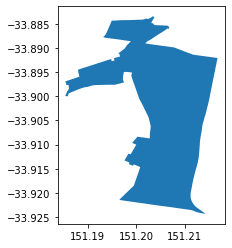

In [11]:
# let's isolate the sa2s that make up our case study areas of Redfern/Waterloo
red_wat_gdf = sa2_shape16[(sa2_shape16.SA2_MAIN16=='117031335')
                          |(sa2_shape16.SA2_MAIN16=='117031338')]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
red_wat_simple = red_wat_gdf[['SA2_MAIN16','geometry', "SA4_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
red_wat_sgdf=red_wat_simple.dissolve(by="SA4_NAME16")
red_wat_sgdf.plot()

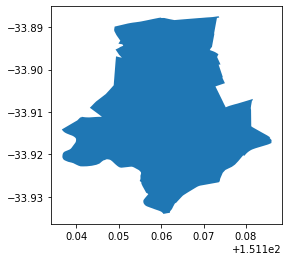

In [12]:
# isolate the sa2s that make up our case study areas of Marrickville
marr_gdf = sa2_shape16[(sa2_shape16.SA2_MAIN16=='117021326')
                      |(sa2_shape16.SA2_MAIN16=='117021327')
                      |(sa2_shape16.SA2_MAIN16=='117021328')
                      |(sa2_shape16.SA2_MAIN16=='117021328')]

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
marr_simple = marr_gdf[['SA2_MAIN16','geometry', "SA4_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
marr_sgdf=marr_simple.dissolve(by="SA4_NAME16")
marr_sgdf.plot()

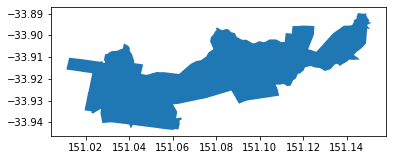

In [13]:
# let's isolate the sa2s that make up our case study areas of Sydenham to Bankstown
t3_corr_gdf = sa2_shape16[(sa2_shape16.SA2_MAIN16=='120031394')
                          |(sa2_shape16.SA2_MAIN16=='120031392')
                          |(sa2_shape16.SA2_MAIN16=='119021363')
                          |(sa2_shape16.SA2_MAIN16=='119021362')
                          |(sa2_shape16.SA2_MAIN16=='119021573')
                          |(sa2_shape16.SA2_MAIN16=='119021574')
                          |(sa2_shape16.SA2_MAIN16=='119021366')
                          |(sa2_shape16.SA2_MAIN16=='119011572')
                          |(sa2_shape16.SA2_MAIN16=='119011571')].copy()

# now let's create a simple rendition of the df so that we can combine its SA2 boundaries
t3_corr_simple = t3_corr_gdf[['SA2_MAIN16','geometry', "GCC_NAME16"]].reset_index()

# "dissolve" or "aggregates" all the polygons that share the same value for the variable we call
t3_corr_sgdf=t3_corr_simple.dissolve(by="GCC_NAME16")
t3_corr_sgdf.plot()

In [14]:
# change the SA2 values to be integers for the merge and drop the unnamed column and t3_corr_dv to create a new 
# one below. 
sa2_w_dv['SA2_MAIN16']=sa2_w_dv['SA2_MAIN16'].astype(int)
sa2_w_dv.drop(['Unnamed: 0'],axis=1,inplace=True)
sa2_shape16['SA2_MAIN16']=sa2_shape16['SA2_MAIN16'].astype(int)

In [15]:
# merge shapefile with dummy variables 
sa2_shape16 = pd.merge(sa2_shape16,sa2_w_dv,on='SA2_MAIN16',how='left')

In [16]:
# create geodataframe out of newly merged dataframe 
sa2_shape16 = gpd.GeoDataFrame(sa2_shape16)

# Calculate Density per SA2

In [17]:
# assign the CRS to be World Geodetic System 
sa2_shape16.crs = {'init':'epsg:4326'}

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [18]:
# perform a spatial join on the UCL SA2s to find density of AirBnB listings per SA2
list_density = gpd.sjoin(airbnb_gdf,sa2_shape16,how='right',op='within')

In [19]:
# pull the info on the new geodataframe
list_density.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 37287 entries, 0 to 264
Data columns (total 84 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   index_left                                    37273 non-null  float64       
 1   id                                            37273 non-null  float64       
 2   listing_url                                   37273 non-null  object        
 3   scrape_id                                     37273 non-null  float64       
 4   last_scraped                                  37273 non-null  datetime64[ns]
 5   name                                          37262 non-null  object        
 6   summary                                       35879 non-null  object        
 7   space                                         26041 non-null  object        
 8   description                                   36319 non-null

In [20]:
# create a group by statement that creates a column of the counts of listings per SA2, or in other words, 
# count the number of geographical points that fall within the boundaries of an SA2 
list_sa2 = pd.DataFrame({'list_per_SA2' : list_density.groupby('SA2_MAIN16')['SA2_MAIN16'].count()}).reset_index()

In [21]:
# merge the count of listings by SA2 and convert it into a geodataframe so that we can create a choropleth map 
list_sa2 = pd.merge(list_sa2,sa2_shape16,on='SA2_MAIN16',how='left')
list_sa2 = gpd.GeoDataFrame(list_sa2)

In [22]:
# create a new variable that finds the number of listings per square kilometer 
list_sa2['listing_density'] = list_sa2.list_per_SA2/list_sa2.AREASQKM16

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


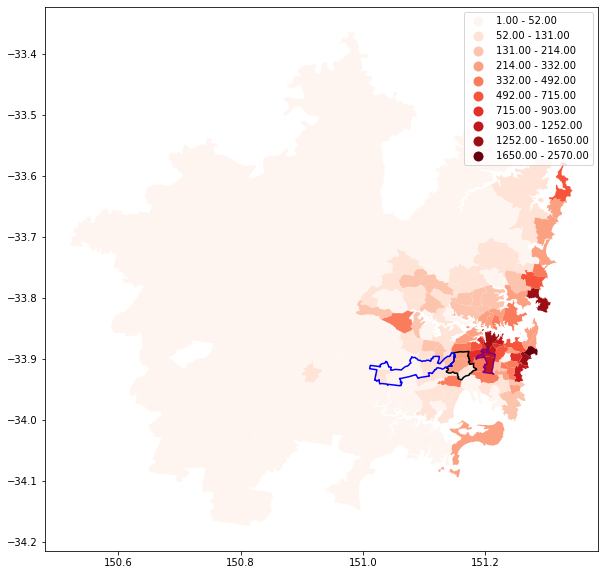

In [23]:
# plot listing per SA2 choropleth map; set the k=10 in te legend to see the deciles in natural breaks using
# fisher jenks method
figure, ax = plt.subplots(figsize=(14,10))
base= list_sa2.plot(column='list_per_SA2', 
                        scheme = 'fisherjenks',
                        k=10,
                        legend=True,  
                        ax=ax,
                        cmap='Reds')

red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Purple", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Black", linewidth = 1.5)
t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Blue", linewidth = 1.5);

## Calculating the number of days listings are unavailable


In [24]:
#Grouping by host IDs how many days out of the year, on average, are their listings available?
h_n_list_av = pd.DataFrame(airbnb_df.groupby('property_type').agg({'availability_365':['mean','count']}))
h_n_list_av.reset_index(inplace=True)
h_n_list_av.columns = ['_'.join(col).strip('_') for col in h_n_list_av.columns]
h_n_list_av.head()
# calculate the percentage of the calendar year that these are not available for long term rentals
h_n_list_av['pct_year'] =  round(h_n_list_av['availability_365_mean']/365,3)
h_n_list_av.sort_values(by='availability_365_mean',ascending= False)

,property_type,availability_365_mean,availability_365_count,pct_year
1,Cabin,197.710145,69,0.542
8,Serviced apartment,183.631579,228,0.503
9,Tiny house,155.571429,49,0.426
11,Villa,150.898148,324,0.413
5,Guesthouse,144.610000,500,0.396
4,Guest suite,131.574713,609,0.360
3,Cottage,123.510638,141,0.338
7,Loft,102.721992,241,0.281
6,House,102.317259,10244,0.280
10,Townhouse,89.557168,1723,0.245


In [25]:
# create a crosstab comparing the average number of days listings are available for Redfern/Waterloo
pd.crosstab(list_density.property_type, 
            list_density.red_wat_dv, 
            values = list_density.availability_365, 
            aggfunc=['mean','count'])

mean                count        
red_wat_dv                   0           1        0       1
property_type                                              
Apartment            78.500000   55.220130  21042.0  1381.0
Cabin               191.046875         NaN     64.0     NaN
Condominium          79.585366   61.697674    738.0    86.0
Cottage             116.540323  108.500000    124.0     2.0
Guest suite         131.710660  133.846154    591.0    13.0
Guesthouse          144.736402  126.315789    478.0    19.0
House               102.834991   71.027950   9854.0   322.0
Loft                104.895238   88.000000    210.0    31.0
Serviced apartment  189.190476  105.117647    210.0    17.0
Tiny house          152.520833  302.000000     48.0     1.0
Townhouse            90.376590   80.563758   1572.0   149.0
Villa               151.003135   45.500000    319.0     2.0

In [26]:
# create a crosstab comparing the average number of days listings are available for Marrickville
pd.crosstab(list_density.property_type, 
            list_density.marrick_dv, 
            values = list_density.availability_365, 
            aggfunc=['mean','count'])

mean                count       
marrick_dv                   0           1        0      1
property_type                                             
Apartment            77.265031   44.244444  22288.0  135.0
Cabin               191.046875         NaN     64.0    NaN
Condominium          77.461071  183.500000    822.0    2.0
Cottage             117.186992   84.666667    123.0    3.0
Guest suite         131.571667  159.500000    600.0    4.0
Guesthouse          143.220619  176.833333    485.0   12.0
House               102.098607   80.285714  10050.0  126.0
Loft                103.150000    0.000000    240.0    1.0
Serviced apartment  182.894273         NaN    227.0    NaN
Tiny house          155.916667  139.000000     48.0    1.0
Townhouse            90.201405    0.923077   1708.0   13.0
Villa               149.398119  301.500000    319.0    2.0

In [27]:
# create a crosstab comparing the average number of days listings are available for Sydenham/Bankstown Corridor
pd.crosstab(list_density.property_type, 
            list_density.t3_corr_dv, 
            values = list_density.availability_365, 
            aggfunc=['mean','count'])

mean                count       
t3_corr_dv                   0           1        0      1
property_type                                             
Apartment            76.301104  128.132931  22092.0  331.0
Cabin               191.046875         NaN     64.0    NaN
Condominium          77.431204  101.100000    814.0   10.0
Cottage             116.412698         NaN    126.0    NaN
Guest suite         131.911074  120.250000    596.0    8.0
Guesthouse          144.402062  129.083333    485.0   12.0
House               101.727336  110.603448  10060.0  116.0
Loft                102.620833  127.000000    240.0    1.0
Serviced apartment  182.097778  272.500000    225.0    2.0
Tiny house          152.458333  305.000000     48.0    1.0
Townhouse            89.175986  116.636364   1699.0   22.0
Villa               150.003165  172.000000    316.0    5.0

## Analyzing the patterns of growth for different AirBnB property types

In [28]:
# create a column that counts each value 
airbnb_df['count'] = 1 
# set the variable prop_year to a pivot table that aggregates the property types by their years, and gets a sum of 
# the values 
prop_year = pd.pivot_table(airbnb_df,index='property_type',columns='hs_year',values='count',aggfunc=np.sum,fill_value=0)

# reset the index to create a dataframe
prop_year.reset_index(inplace=True)

# change the column names for a melt
prop_year.columns=(['property_type','2009','2010','2011','2012','2013',
                    '2014','2015','2016','2017','2018','2019'])

# melt the data to create a line graph 
prop_year_melt = pd.melt(prop_year, 
        id_vars='property_type',
        value_vars = ['2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'],
        value_name='prop_count')
# output to inspect
prop_year_melt

,property_type,variable,prop_count
0,Apartment,2009,17
1,Cabin,2009,0
2,Condominium,2009,0
3,Cottage,2009,0
4,Guest suite,2009,0
5,Guesthouse,2009,2
6,House,2009,13
7,Loft,2009,2
8,Serviced apartment,2009,0
9,Tiny house,2009,0


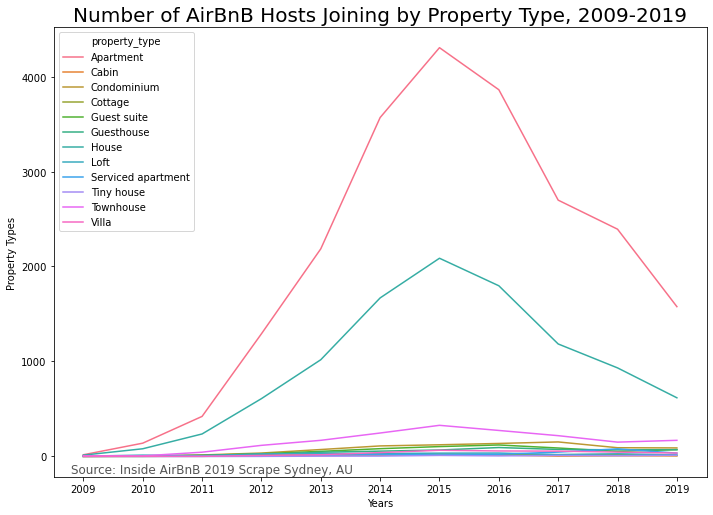

In [29]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title('Number of AirBnB Hosts Joining by Property Type, 2009-2019', fontdict={'fontsize':20})
g = sns.lineplot(x='variable', y='prop_count', data=prop_year_melt, hue='property_type',ax=ax)

plt.xlabel('Years')
plt.ylabel('Property Types')

ax.annotate('Source: Inside AirBnB 2019 Scrape Sydney, AU',
            xy=(0.1, .10),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='#555555')
plt.savefig('hosts_overtime_HnA.png')

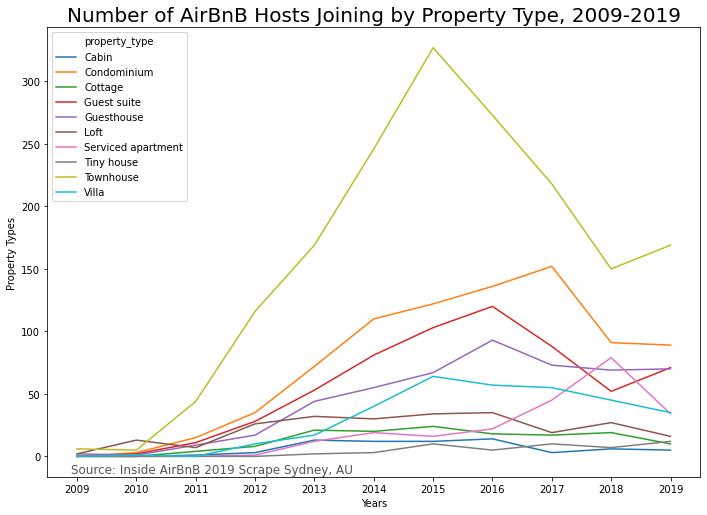

In [30]:
prop_year_melt=prop_year_melt[prop_year_melt.property_type!='Apartment']
prop_year_melt=prop_year_melt[prop_year_melt.property_type!='House']

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
ax.set_title('Number of AirBnB Hosts Joining by Property Type, 2009-2019', fontdict={'fontsize':20})
g = sns.lineplot(x='variable', y='prop_count', data=prop_year_melt, hue='property_type',ax=ax)
plt.xlabel('Years')
plt.ylabel('Property Types')
ax.annotate('Source: Inside AirBnB 2019 Scrape Sydney, AU',
            xy=(0.1, .10),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='#555555')
plt.savefig('hosts_overtime.png')

## Calculating the number of days listings are unavailable. 

In [31]:
#Grouping by host IDs how many days out of the year, on average, are their listings available?
h_n_list_av = pd.DataFrame(airbnb_df.groupby('property_type').agg({'availability_365':['mean','count']}))
h_n_list_av.reset_index(inplace=True)
h_n_list_av.columns = ['_'.join(col).strip('_') for col in h_n_list_av.columns]
h_n_list_av.head()
# calculate the percentage of the calendar year that these are not available for long term rentals
h_n_list_av['pct_year'] =  round(h_n_list_av['availability_365_mean']/365,3)
h_n_list_av.sort_values(by='availability_365_mean',ascending= False)

,property_type,availability_365_mean,availability_365_count,pct_year
1,Cabin,197.710145,69,0.542
8,Serviced apartment,183.631579,228,0.503
9,Tiny house,155.571429,49,0.426
11,Villa,150.898148,324,0.413
5,Guesthouse,144.610000,500,0.396
4,Guest suite,131.574713,609,0.360
3,Cottage,123.510638,141,0.338
7,Loft,102.721992,241,0.281
6,House,102.317259,10244,0.280
10,Townhouse,89.557168,1723,0.245


In [32]:
# create a crosstab comparing the average number of days listings are available for Redfern/Waterloo
pd.crosstab(list_density.property_type, 
            list_density.red_wat_dv, 
            values = list_density.availability_365, 
            aggfunc=['mean','count'])

mean                count        
red_wat_dv                   0           1        0       1
property_type                                              
Apartment            78.500000   55.220130  21042.0  1381.0
Cabin               191.046875         NaN     64.0     NaN
Condominium          79.585366   61.697674    738.0    86.0
Cottage             116.540323  108.500000    124.0     2.0
Guest suite         131.710660  133.846154    591.0    13.0
Guesthouse          144.736402  126.315789    478.0    19.0
House               102.834991   71.027950   9854.0   322.0
Loft                104.895238   88.000000    210.0    31.0
Serviced apartment  189.190476  105.117647    210.0    17.0
Tiny house          152.520833  302.000000     48.0     1.0
Townhouse            90.376590   80.563758   1572.0   149.0
Villa               151.003135   45.500000    319.0     2.0

In [33]:
# create a crosstab comparing the average number of days listings are available for Marrickville
pd.crosstab(list_density.property_type, 
            list_density.marrick_dv, 
            values = list_density.availability_365, 
            aggfunc=['mean','count'])

mean                count       
marrick_dv                   0           1        0      1
property_type                                             
Apartment            77.265031   44.244444  22288.0  135.0
Cabin               191.046875         NaN     64.0    NaN
Condominium          77.461071  183.500000    822.0    2.0
Cottage             117.186992   84.666667    123.0    3.0
Guest suite         131.571667  159.500000    600.0    4.0
Guesthouse          143.220619  176.833333    485.0   12.0
House               102.098607   80.285714  10050.0  126.0
Loft                103.150000    0.000000    240.0    1.0
Serviced apartment  182.894273         NaN    227.0    NaN
Tiny house          155.916667  139.000000     48.0    1.0
Townhouse            90.201405    0.923077   1708.0   13.0
Villa               149.398119  301.500000    319.0    2.0

In [34]:
# create a crosstab comparing the average number of days listings are available for Sydenham/Bankstown Corridor
pd.crosstab(list_density.property_type, 
            list_density.t3_corr_dv, 
            values = list_density.availability_365, 
            aggfunc=['mean','count'])

mean                count       
t3_corr_dv                   0           1        0      1
property_type                                             
Apartment            76.301104  128.132931  22092.0  331.0
Cabin               191.046875         NaN     64.0    NaN
Condominium          77.431204  101.100000    814.0   10.0
Cottage             116.412698         NaN    126.0    NaN
Guest suite         131.911074  120.250000    596.0    8.0
Guesthouse          144.402062  129.083333    485.0   12.0
House               101.727336  110.603448  10060.0  116.0
Loft                102.620833  127.000000    240.0    1.0
Serviced apartment  182.097778  272.500000    225.0    2.0
Tiny house          152.458333  305.000000     48.0    1.0
Townhouse            89.175986  116.636364   1699.0   22.0
Villa               150.003165  172.000000    316.0    5.0

## Analyzing trends for number of hosts that have more than one listing in AirBnB

I think it's important to separate out the groups that have more than one AirBnB listing because of our conceptualization of commodification of housing affects the market. In our literature review, we found that about 1/5 of Australians own more than one home. If that's the case, let's see how many times there are more than two listings, and then how the distribution of them look in a map of the Sydney UCL

### Question 1: Of the hosts that have >= 2 properties, how are they distributed spatially?

Methodology: 

1. Isolate host_ids where hosts own two or more properties
1. 

In [35]:
from scipy import ndimage
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6

In [36]:
#create a dataframe out of a groupby that groups host IDs and counts the listing IDs in associated to them
test_df = pd.DataFrame({'cnt_list_host' : airbnb_df.groupby('host_id')['id'].count()}).reset_index()
# create a new geodataframe that only has listing id, host id, and geometry
test_gdf2 = airbnb_gdf[['id','host_id','geometry']]
# test merge 
test_merge = pd.merge(test_df,test_gdf2,on='host_id',how='left')
# isolate new dataframe to only have listings where the count of listings per host are >=2
#test_merge = test_merge[test_merge.cnt_list_host>=2]
# create a new geodataframe
tm_gdf = gpd.GeoDataFrame(test_merge, crs=crs)
#perform a geospatial join on the new test dataframe so that we can perform this at the sa2 level
merge_gdf = gpd.sjoin(tm_gdf,sa2_shape16,how='right',op='within')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [37]:
merge_gdf.dropna(inplace=True)
merge_gdf= merge_gdf.reset_index()

In [38]:
merge_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          1009 non-null   int64   
 1   index_left     1009 non-null   float64 
 2   host_id        1009 non-null   float64 
 3   cnt_list_host  1009 non-null   float64 
 4   id             1009 non-null   float64 
 5   SA2_MAIN16     1009 non-null   int32   
 6   SA2_5DIG16     1009 non-null   object  
 7   SA2_NAME16     1009 non-null   object  
 8   SA3_CODE16     1009 non-null   object  
 9   SA3_NAME16     1009 non-null   object  
 10  SA4_CODE16     1009 non-null   object  
 11  SA4_NAME16     1009 non-null   object  
 12  GCC_CODE16     1009 non-null   object  
 13  GCC_NAME16     1009 non-null   object  
 14  STE_CODE16     1009 non-null   object  
 15  STE_NAME16     1009 non-null   object  
 16  AREASQKM16     1009 non-null   float64 
 17  Name           1009 non-n

In [39]:
merge_gdf.cnt_list_host.value_counts()

1.0      622
2.0      156
3.0       59
4.0       33
75.0      15
16.0      13
6.0       13
13.0      11
5.0       10
12.0       8
47.0       7
9.0        7
7.0        7
14.0       7
38.0       5
11.0       5
53.0       5
37.0       3
153.0      2
23.0       2
10.0       2
24.0       2
18.0       2
105.0      2
104.0      2
30.0       1
25.0       1
35.0       1
22.0       1
28.0       1
57.0       1
173.0      1
34.0       1
145.0      1
Name: cnt_list_host, dtype: int64

In [40]:
tm_gdf.head()

,host_id,cnt_list_host,id,geometry
0,12894,1,35596218,POINT (151.26181 -33.88960)
1,14093,2,8974359,POINT (151.22417 -33.86763)
2,14093,2,9743495,POINT (151.22496 -33.86874)
3,15030,2,28720008,POINT (151.07486 -33.84873)
4,15030,2,32124043,POINT (151.07537 -33.84773)


In [41]:
tm_gdf = tm_gdf[tm_gdf.cnt_list_host>=2]

In [42]:
entrances.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Train_St    715 non-null    object  
 1   Street_N    715 non-null    object  
 2   Street_T    715 non-null    object  
 3   Entrance    715 non-null    object  
 4   index_righ  715 non-null    float64 
 5   UCL_CODE16  715 non-null    object  
 6   UCL_NAME16  715 non-null    object  
 7   SSR_CODE16  715 non-null    object  
 8   SSR_NAME16  715 non-null    object  
 9   SOS_CODE16  715 non-null    object  
 10  SOS_NAME16  715 non-null    object  
 11  STE_CODE16  715 non-null    object  
 12  STE_NAME16  715 non-null    object  
 13  AREASQKM16  715 non-null    float64 
 14  geometry    715 non-null    geometry
dtypes: float64(2), geometry(1), object(12)
memory usage: 83.9+ KB


C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:138: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pysal\viz\mapclassify\classifiers.py:140: UserWarning: Warning: setting k to 8
  Warn("Warning: setting k to %d" % k_q, UserWarning)


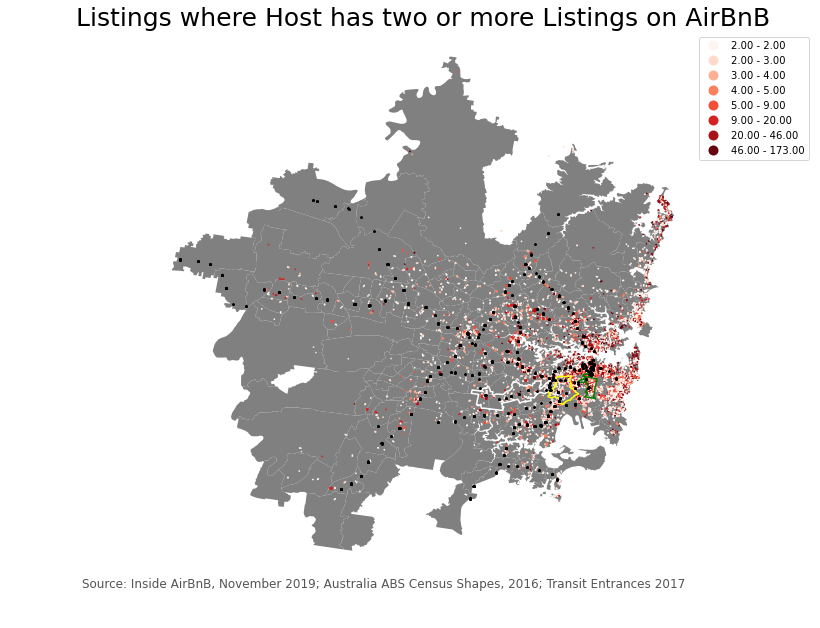

In [43]:
figure, ax = plt.subplots(figsize=(14,10))
base = sa2_shape16.plot(ax=ax,color='gray')
tm_gdf.plot(column="cnt_list_host", 
              scheme = "quantiles", 
              k = 10, 
              legend=True, 
              ax=base, 
              cmap="Reds",
             markersize=.5)

t3_corr_sgdf.plot(ax=base, facecolor='none', edgecolor = "White", linewidth = 1.5)
red_wat_sgdf.plot(ax=base, facecolor='none', edgecolor = "Green", linewidth = 1.5)
marr_sgdf.plot(ax=base, facecolor='none', edgecolor = "Yellow", linewidth = 1.5)
entrances.plot(ax=base, marker='*', color='Black', markersize=5);

lims=plt.axis("equal")
ax.set_axis_off()

ax.set_title('Listings where Host has two or more Listings on AirBnB', fontdict={'fontsize':25})

ax.annotate('Source: Inside AirBnB, November 2019; Australia ABS Census Shapes, 2016; Transit Entrances 2017',
            xy=(0.1, .08),  
            xycoords='figure fraction', 
            horizontalalignment='left', 
            verticalalignment='top', 
            fontsize=12, 
            color='#555555')

plt.show()

Future research steps: 

I think it'd be really fun to do a proximity calculation to see what the change in price looks like depending on how far away an AirBnB listing is from a transit stop, since it seems like they tend to be close to transit lines. 

In [69]:
list_density = gpd.sjoin(airbnb_gdf,sa2_shape16,how='right',op='within')

In [70]:
two_more_dist = list_density[list_density.calculated_host_listings_count>=2]
two_more_dist = two_more_dist[two_more_dist.room_type =='Entire home/apt']
two_more_dist = two_more_dist[(two_more_dist.property_type =='Apartment')|
                             (two_more_dist.property_type =='House')]


In [76]:
two_more_dist.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7728 entries, 0 to 263
Data columns (total 85 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   index_left                                    7728 non-null   float64       
 1   id                                            7728 non-null   float64       
 2   listing_url                                   7728 non-null   object        
 3   scrape_id                                     7728 non-null   float64       
 4   last_scraped                                  7728 non-null   datetime64[ns]
 5   name                                          7728 non-null   object        
 6   summary                                       7545 non-null   object        
 7   space                                         6332 non-null   object        
 8   description                                   7631 non-null  

In [77]:
# create a crosstab comparing the average number of days listings are available for Sydenham/Bankstown Corridor
pd.crosstab(two_more_dist.property_type, 
            two_more_dist.marrick_dv, 
            values = two_more_dist.id, 
            aggfunc='count')

marrick_dv,0,1
property_type,,
Apartment,6048,20
House,1648,12


In [78]:
airbnb_df.groupby('host_id').agg('count')

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_name,host_since,host_location,host_about,host_neighbourhood,host_listings_count,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,license,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hs_year,geometry,count
host_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12894,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
14093,2,2,2,2,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2
15030,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,0,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2
17020,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
17061,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,0,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306692071,1,1,1,1,1,1,0,1,0,0,1,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1
306700375,1,1,1,1,1,1,0,1,0,0,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1
307013570,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1


In [79]:
two_more_dist.groupby('host_id').agg('count')

,index_left,id,listing_url,scrape_id,last_scraped,name,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_name,host_since,host_location,host_about,host_neighbourhood,host_listings_count,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,license,is_business_travel_ready,cancellation_policy,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,hs_year,count,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,Name,geometry,red_wat_dv,marrick_dv,t3_corr_dv
host_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17331.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,0,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
55948.0,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
57949.0,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,1,1,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
67766.0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,0,1,1,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
113874.0,57,57,57,57,57,57,57,50,57,36,21,36,47,50,40,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,57,1,57,0,0,57,57,57,57,57,57,57,57,57,57,0,57,57,57,57,57,57,33,57,57,57,57,57,57,57,57,57,57,57,57,57,57,0,57,57,57,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302411939.0,1,1,1,1,1,1,1,0,1,0,0,0,1,0,0,1,1,1,0,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1
302599229.0,2,2,2,2,2,2,2,2,2,0,2,0,2,0,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,0,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
304046030.0,2,2,2,2,2,2,2,2,2,0,2,0,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,0,0,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,0,2,2,2,2
